# Classificação de dados usando LLMs

In [1]:
import chardet
import pandas as pd

# Detect the file encoding
with open("tweets.csv", "rb") as file:
    raw_data = file.read()
    result = chardet.detect(raw_data)
    encoding = result["encoding"]
print(f"Detected encoding: {encoding}")

# Read with detected encoding
df = pd.read_csv("tweets.csv", encoding=encoding)[["text", "sentiment"]]

# Save as UTF-8 for future use
df.to_csv("tweets_utf8.csv", encoding="utf-8", index=False)

df.head()


Detected encoding: Windows-1252


,text,sentiment
0,Last session of the day http://twitpic.com/67ezh,neutral
1,Shanghai is also really exciting (precisely -...,positive
2,"Recession hit Veronique Branquinho, she has to...",negative
3,happy bday!,positive
4,http://twitpic.com/4w75p - I like it!!,positive


In [2]:
# Get 2 random samples from each sentiment
samples = []
for sentiment in ["positive", "negative", "neutral"]:
    sentiment_samples = df[df["sentiment"] == sentiment].sample(n=2, random_state=42)
    samples.append(sentiment_samples)

# Combine samples and format output
result_samples = pd.concat(samples)
examples = ""
for _, row in result_samples.iterrows():
    examples += f"Tweet: {row['text']}\nSentiment: {row['sentiment']}\n\n"

print(examples)


Tweet:  Its WoW! effect  Thanks for the update.
Sentiment: positive

Tweet: In a really Good mood for absolutely no reason  tee her
Sentiment: positive

Tweet: LAZZZZZZZZZZZZZZZY MONDAY !! Bank Holiday  Nicole why haven`t u direct msged me yet ?!!!
Sentiment: negative

Tweet:  Sorry bro  That`s rough.
Sentiment: negative

Tweet: Gonna go and see my sister at Mount Sinai ....  she`s there for at least another 24 hours.
Sentiment: neutral

Tweet: I`m such a saddo, haha. But that actually makes me really happy. Warrens dead though
Sentiment: neutral




In [13]:
# Create a balanced sample of 15 examples per class
balanced_samples = []

for sentiment in ["positive", "negative", "neutral"]:
    # Sample 15 examples from each class
    class_samples = df[df["sentiment"] == sentiment].sample(n=40, random_state=42)

    # Add tuples of (text, sentiment) to the list
    balanced_samples.extend(
        list(zip(class_samples["text"], class_samples["sentiment"]))
    )

# Convert to tuple for immutability
balanced_samples = tuple(balanced_samples)

# Verify the sample
print(f"Total samples: {len(balanced_samples)}")
print("\nFirst few examples:")
for text, sentiment in balanced_samples[:3]:
    print(f"Sentiment: {sentiment}")
    print(f"Text: {text}\n")


Total samples: 120

First few examples:
Sentiment: positive
Text:  Its WoW! effect  Thanks for the update.

Sentiment: positive
Text: In a really Good mood for absolutely no reason  tee her

Sentiment: positive
Text: Loves the 2nd half of even days, orch and jazz band with daddy



In [14]:
system_prompt = f"""You are an expert sentiment classifier. You'll be given the text of a tweet and your job is to analyze it and return the sentiment expressed as either positive, negative, or neutral.
First, study these examples carefully and understand the patterns of classification:

{examples}

For each new tweet you analyze, please:
1. First explain your reasoning, considering the language, emotion, and context
2. Then provide your final classification as either: positive, negative, or neutral
"""


In [18]:
import os
from dotenv import load_dotenv
from openai import OpenAI
from instructor import from_openai
from pydantic import BaseModel, Field

load_dotenv()

client = OpenAI(
    api_key=os.getenv("OPENROUTER_API_KEY"), base_url="https://openrouter.ai/api/v1"
)

instructor_client = from_openai(
    client=client,
    model="deepseek/deepseek-chat",
)


class SentimentAnalysis(BaseModel):
    reasoning: str = Field(
        ..., title="An explanaiton of the reasoning behind the sentiment classification"
    )
    sentiment: str = Field(..., title="The sentiment classification of the tweet")


In [19]:
results = {
    "text": [],
    "classification": [],
    "model_classification": [],
    "reasoning": [],
}

# Iterate over the balanced samples
for text, original_classification in balanced_samples:
    classification = instructor_client.messages.create(
        response_model=SentimentAnalysis,
        messages=[
            {
                "role": "system",
                "content": system_prompt,
            },
            {
                "role": "user",
                "content": text,
            },
        ],
        temperature=1,
    )

    # Add results to our lists
    results["text"].append(text)
    results["classification"].append(original_classification)
    results["model_classification"].append(classification.sentiment)
    results["reasoning"].append(classification.reasoning)

# Create DataFrame from results
results_df = pd.DataFrame(results)


InstructorRetryException: Instructor does not support multiple tool calls, use List[Model] instead

In [16]:
results_df.head()


,text,classification,model_classification,reasoning
0,Its WoW! effect Thanks for the update.,positive,positive,The tweet expresses a sense of excitement and ...
1,In a really Good mood for absolutely no reason...,positive,positive,The tweet expresses a positive state of mind (...
2,"Loves the 2nd half of even days, orch and jazz...",positive,positive,The tweet expresses a positive sentiment as it...
3,last week and I interviewed and we told him...,positive,positive,The tweet expresses a positive sentiment due t...
4,Studio Ghibli for this year; Ponyo! http://bit...,positive,positive,The tweet expresses excitement about the Studi...


Overall Accuracy: 78.33%

Per-class metrics:
          Precision  Recall  F1-score
Positive   0.755102   0.925  0.831461
Negative   0.787234   0.925  0.850575
Neutral    0.833333   0.500  0.625000

Weighted Averages:
Precision: 79.19%
Recall: 78.33%
F1-score: 76.90%


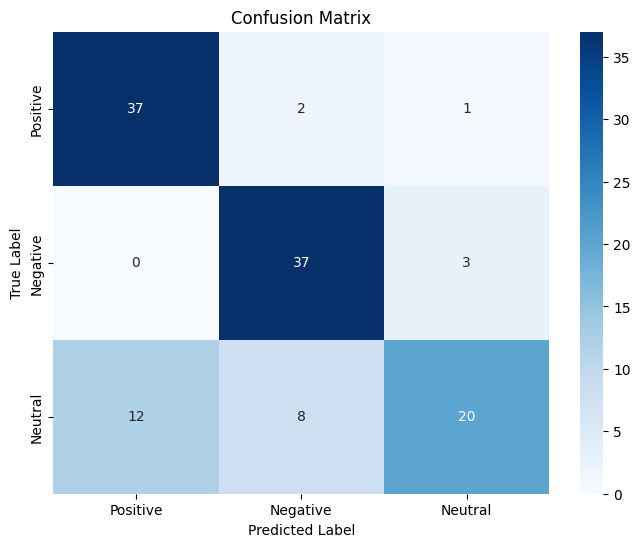


Agreement percentage by sentiment:
classification
negative    0.925
neutral     0.500
positive    0.925
dtype: float64


/tmp/ipykernel_17045/4293953673.py:86: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["classification"] == x["model_classification"]).mean())


In [17]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate overall accuracy
accuracy = accuracy_score(
    results_df["classification"], results_df["model_classification"]
)

# Calculate per-class precision, recall, and F1 score
precision = precision_score(
    results_df["classification"],
    results_df["model_classification"],
    average=None,
    labels=["positive", "negative", "neutral"],
)
recall = recall_score(
    results_df["classification"],
    results_df["model_classification"],
    average=None,
    labels=["positive", "negative", "neutral"],
)
f1 = f1_score(
    results_df["classification"],
    results_df["model_classification"],
    average=None,
    labels=["positive", "negative", "neutral"],
)

# Calculate weighted averages
weighted_precision = precision_score(
    results_df["classification"], results_df["model_classification"], average="weighted"
)
weighted_recall = recall_score(
    results_df["classification"], results_df["model_classification"], average="weighted"
)
weighted_f1 = f1_score(
    results_df["classification"], results_df["model_classification"], average="weighted"
)

# Create confusion matrix
cm = confusion_matrix(
    results_df["classification"],
    results_df["model_classification"],
    labels=["positive", "negative", "neutral"],
)

# Print metrics
print(f"Overall Accuracy: {accuracy:.2%}")
print("\nPer-class metrics:")
metrics_df = pd.DataFrame(
    {"Precision": precision, "Recall": recall, "F1-score": f1},
    index=["Positive", "Negative", "Neutral"],
)
print(metrics_df)

print(f"\nWeighted Averages:")
print(f"Precision: {weighted_precision:.2%}")
print(f"Recall: {weighted_recall:.2%}")
print(f"F1-score: {weighted_f1:.2%}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Positive", "Negative", "Neutral"],
    yticklabels=["Positive", "Negative", "Neutral"],
)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Calculate and display agreement percentage for each sentiment
sentiment_agreement = (
    results_df.groupby("classification")
    .apply(lambda x: (x["classification"] == x["model_classification"]).mean())
    .round(3)
)

print("\nAgreement percentage by sentiment:")
print(sentiment_agreement)
